## Tacotron 2 inference code 
Edit the variables **checkpoint_path** and **text** to match yours and run the entire code to generate plots of mel outputs, alignments and audio synthesis from the generated mel-spectrogram using Griffin-Lim.

#### Import libraries and setup matplotlib

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser

In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower', 
                       interpolation='none')

#### Setup hparams

In [3]:
hparams = create_hparams()
hparams.sampling_rate = 22050

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



#### Load model from checkpoint

In [4]:
checkpoint_path = "checkpoint_52000"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval()#.half()

#### Load WaveGlow for mel2audio synthesis and denoiser

In [5]:
waveglow_path = 'waveglow_256channels_universal_v5.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval()#.half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\torch\serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\torch\serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\torch\serialization.py:786: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has change

#### Prepare text input

In [16]:
text = "謝る必要はない、むしろ、私こそごめんなさい。"
sequence = np.array(text_to_sequence(text, ['japanese_accent_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Decode text input and plot results

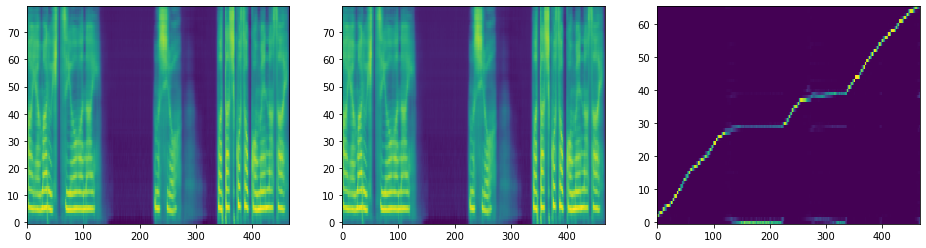

In [17]:
%matplotlib inline
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Synthesize audio from spectrogram using WaveGlow

In [18]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.display(ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate))
# (Optional) Remove WaveGlow bias
audio_denoised = denoiser(audio, strength=2)[:, 0]
ipd.display(ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate))

#### Load HifiGAN

In [19]:
sys.path.append('hifigan-tool/')
# 文件结构如下：
# -hifigan-tool
#  |_hifigan
#    |_ __init__.py
#    |_ models.py
#    |_ inference.py
#    |_ inference_e2e.py
#    |_ 其他文件...

# 若无 __init__.py ，新建一个 __init__.py，加入一行：
# from .models import Generator

# 同时将 models.py 第六行修改为：
# from .utils import init_weights, get_padding

In [20]:
from hifigan.models import Generator as HifiGAN
import json
import os

In [21]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

In [22]:
with open("hifigan-tool/hifigan/config_v1.json") as f: # 从 github 下载 config.json
    data = f.read()
json_config = json.loads(data)
h = AttrDict(json_config)
hifiGAN = HifiGAN(h).cuda()

In [23]:
def load_checkpoint(filepath, device):
    assert os.path.isfile(filepath)
    print("Loading '{}'".format(filepath))
    checkpoint_dict = torch.load(filepath, map_location=device)
    print("Complete.")
    return checkpoint_dict

In [24]:
state_dict_g = load_checkpoint("hifigan-tool/hifigan/g_atri_hifigan_02510000", "cuda") # 从 github 下载 g_atri_hifigan_02510000
hifiGAN.load_state_dict(state_dict_g['generator'])

Loading 'hifigan-tool/hifigan/g_atri_hifigan_02510000'
Complete.


<All keys matched successfully>

#### Synthesize audio from spectrogram using HifiGAN

In [25]:
x = torch.FloatTensor(mel_outputs_postnet.float().data.cpu().numpy()[0]).cuda()
y_g_hat = hifiGAN(x)
audio = y_g_hat.squeeze()
audio = audio * 32768.0
audio = audio.cpu().detach().numpy().astype('int16')
ipd.display(ipd.Audio(audio, rate=hparams.sampling_rate))

RuntimeError: CUDA out of memory. Tried to allocate 16.00 MiB (GPU 0; 4.00 GiB total capacity; 3.23 GiB already allocated; 0 bytes free; 3.41 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF